### `chat_id ` из Телеграма:

In [ ]:
457863109

##  <ins>Задание 1.</ins>

### Проект 2.1 "A/B тест на процессе продажных обзвонов"

**Контекст:**
Мы считаем, что наш продукт достаточно дорогой для клиента. У нас есть гипотеза, что уменьшение цены продукта позволит повысить частоту продаж и суммарно увеличит доходность продукта.
        
**Тест:**
Мы проводим тест, в рамках которого контролем является продажа продукта со старой ценой, а тестом — продажа продукта с новой ценой. Целью этого теста является проверка гипотезы роста доходности нашего продукта из-за уменьшения тарифа.

**Статистические вводные:**
Уровень значимости 5%. Мы хотели бы различать 5%-ное изменение целевой метрики с вероятностью 80%.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("hist_telesales.csv")
df.head()

,ID,Флаг дозвона,Флаг продажи,Расходы,PV,NPV
0,0,1,0,90,0,-90
1,1,0,0,5,0,-5
2,2,0,0,68,0,-68
3,3,1,0,22,0,-22
4,4,1,0,22,0,-22


**Описание данных:**

Процесс продажи устроен следующим образом:

* создаётся задание на звонок человеку;
* оператор берёт задание и пытается дозвониться до человека;
* если не дозванивается, мы несём некоторые затраты на время оператора и поддержку инфраструктуры;
* если дозванивается, пытается продать наш продукт;
* если продал, мы имеем некоторый заработок (PV) и повышенные расходы (в том числе на вознаграждение оператора).

Описание колонок в исторических данных:

* ID - номер задания на звонок
* Флаг дозвона - 1 если в рамках задания мы дозвонились человеку, иначе 0
* Флаг продажи - 1 если в рамках задания мы продали наш продукт человеку, иначе 0
* Расходы - сумма затрат на задание
* PV - 0 если мы не продали наш продукт, иначе = PV проданного продукта
* NPV = PV - Расходы

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72161 entries, 0 to 72160
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   ID            72161 non-null  int64
 1   Флаг дозвона  72161 non-null  int64
 2   Флаг продажи  72161 non-null  int64
 3   Расходы       72161 non-null  int64
 4   PV            72161 non-null  int64
 5   NPV           72161 non-null  int64
dtypes: int64(6)
memory usage: 3.3 MB


#### Определим целевую метрику и альтернативу

In [4]:
df.sort_values(by='NPV', ascending=False).head()

,ID,Флаг дозвона,Флаг продажи,Расходы,PV,NPV
64928,64928,1,1,111,41255,41144
1701,1701,1,1,100,28246,28146
42493,42493,1,1,440,18543,18103
18651,18651,1,1,545,12729,12184
71716,71716,1,1,451,11782,11331


**В качестве целевой метрики выберем средний NPV по клиентам** — он будет легче интерпретироваться в отличие от суммарного значения. Медианное значение не выбирается по причине того, что в данном случае невозможен какой-то фрод, который мог бы породить большое число ненужных выбросов. Одновременно с этим, нам нет смысла выкидывать из обозрения успешные по доходности кейсы продаж (ведь это будет говорить об эффективности свежевыстроенного процесса), чем грешит медиана.

Теперь мы можем сформулировать гипотезу (H0) и альтернативу (H1):
* **Гипотеза H0:** средний NPV при уменьшении стоимости тарифа не изменится.
* **Альтернатива H1:** средний NPV при уменьшении стоимости тарифа увеличится.

Обоснование выбора альтернативы: при тестировании гипотезы в качестве альтернативы удобно выбирать то, что мы **пытаемся выявить.** А выявить мы пытаемся что доходность нашего продукта (наша целевая метрика) увеличится.

#### Вычислим размеры выборок для теста и контроля

Используем формулу $N=\frac{\sigma^2(z_{1-\alpha}-z_\beta)^2}{k*\Delta^2}$

Где $\Delta$ — это метрика MDE, вычисляемая в нашем случае как MDE = желаемое изменение метрики * значение метрики на контроле

In [5]:
from scipy.stats import norm

alpha = 0.05
beta = 0.2
k=0.5

quantile_1 = norm.ppf(1-alpha)
quantile_2 = norm.ppf(beta)
var = np.var(df.NPV)
MDE=0.05*np.mean(df.NPV)

sample_size = (var*(quantile_1-quantile_2)**2)/(k*MDE**2)
sample_size

28671.429203969576

Заключаем, что размер выборки для теста и контроля равен 28671 человек.

**ПОЛУЧЕННЫЙ КОД ВЫБОРКИ – 4928**

Полученные выборки теста и контроля:

In [6]:
df_test = pd.read_csv("Тест.csv")
df_control = pd.read_csv("Контроль.csv")

In [7]:
df_test.head()

,ID,Флаг дозвона,Флаг продажи,Расходы,PV,NPV
0,0,0,0,67,0,-67
1,1,1,1,408,1539,1131
2,2,1,0,32,0,-32
3,3,1,0,33,0,-33
4,4,0,0,16,0,-16


In [8]:
df_control.head()

,ID,Флаг дозвона,Флаг продажи,Расходы,PV,NPV
0,0,0,0,17,0,-17
1,1,0,0,96,0,-96
2,2,0,0,34,0,-34
3,3,1,1,980,1353,373
4,4,0,0,6,0,-6


#### Проведём односторонний z-test на проверку равенства средних выборок

In [9]:
from statsmodels.stats.weightstats import ztest

mean_control = np.mean(df_control.NPV)

ztest(x1=df_test.NPV, x2=df_control.NPV, value=0, alternative='larger')

(4.109980262573307, 1.978464687482222e-05)

**Заключение:** p-value > 0.05, следовательно мы отвергаем нулевую гипотезу о равенстве средних и принимаем альтернативу о том, что значение метрики на тесте больше, чем на контроле. Таким образом, мы заключаем, что новый вариант продажи с новой ценой действительно приводит к росту доходности продукта, что и было нашей изначальной гипотезой.

##  <ins>Задание 2.</ins>

### Проект 2.2 "A/B тест на процессе оформления кредитных карт"

**Контекст:** ЦБ смягчило правило, ограничивающее варианты продажи услуги. Мы хотим попробовать более агрессивную продажу услуги, но боимся, что это повлияет на экономику основного продукта (КК) из-за негатива клиентов.

**Тест:** Мы проводим тест, в рамках которого мы разбиваем весь поток на две части равновероятно, где одной части (контролю) мы будем предлагать услугу текущим способом, а второй части (тесту) — новым более агрессивным способом. Целью этого теста является увеличение доходности КК + услуги.

**Статистические вводные:** Проверка однородности выбранного параметра осуществяется с уровнем значимости 2%. Уровень значимости 5%. Мы хотели бы различать 3%-ное изменение целевой метрики с вероятностью 85%.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("hist_credit_card.csv")
df.head()

,ID,Возраст,Доход клиента,Вероятность банкротства,Флаг утилизации счёта,Расходы,PV КК,PV услуги,NPV
0,0,19,21620.835463,0.138061,0,102,0,0,-102
1,1,27,24897.990863,0.035508,1,409,11686,1754,13031
2,2,50,23989.526947,0.098793,0,16,0,0,-16
3,3,18,38442.409756,0.365661,1,788,13738,1578,14528
4,4,24,21291.521612,0.036909,1,1048,6594,2213,7759


**Описание данных:**

Процесс оформления кредитной карты (КК) устроен следующим образом:

* человек заходит на сайт и заполняет информацию о себе (в том числе возраст и доход клиента) для получения кредитной карты;
* человек проходит скоринг (в том числе в рамках которого оценивается вероятность банкротства клиента);
* создаётся заявка на оформление кредитной карты;
* человеку выпускается виртуальная карта, а также предлагается наша услуга к этому счёту;
* с некоторой вероятностью человек утилизирует счёт (начинает им пользоваться);
* если человек не утилизирует счёт, мы несём некоторые затраты на время оператора и поддержку инфраструктуры;
* если человек утилизировал карту, мы имеем некоторый заработок (PV) и повышенные расходы.

Описание колонок в исторических данных:

* ID — номер заявки, прошедшей скоринг
* Возраст — возраст клиента, указанный при оформлении КК
* Доход клиента — доход клиента, указанный при оформлении КК
* Вероятность банкротства — оценка вероятности банкротства клиента, полученная с помощью скоринга по параметрам клиента
* Флаг утилизация счёта — совершение первой расходной операции на счёте КК
* Расходы — сумма затрат на заявку
* PV КК = 0, если счёт не утилизирован, иначе = PV кредитной карты
* PV услуги = 0, если счёт не утилизирован, иначе = PV этой услуги
* NPV = PV КК + PV услуги - Расходы

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123255 entries, 0 to 123254
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ID                       123255 non-null  int64  
 1   Возраст                  123255 non-null  int64  
 2   Доход клиента            123255 non-null  float64
 3   Вероятность банкротства  123255 non-null  float64
 4   Флаг утилизации счёта    123255 non-null  int64  
 5   Расходы                  123255 non-null  int64  
 6   PV КК                    123255 non-null  int64  
 7   PV услуги                123255 non-null  int64  
 8   NPV                      123255 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 8.5 MB


#### Определим целевую метрику и альтернативу

Целью теста является увеличение доходности КК и услуги, поэтому в качестве целевой метрики выберем средний NPV по клиентам. Эта метрика хорошо интерпретируется и допустима ввиду отсутствия фрода в данных (если NPV по каким-то клиентам значительно выше остальных, это означает особенно успешный кейс, который нужно учитывать, поэтому выбор медианы нецелесообразен).

Сформулируем гипотезу (H0) и альтернативу (H1):
* **Гипотеза H0:** средний NPV при уменьшении стоимости тарифа не изменится.
* **Альтернатива H1:** средний NPV при уменьшении стоимости тарифа увеличится.

Обоснование выбора альтернативы: при тестировании гипотезы в качестве альтернативы удобно выбирать то, что мы **пытаемся выявить.** А выявить мы пытаемся что доходность нашего продукта (наша целевая метрика) увеличится.

#### Выбор параметра для проверки однородности

Параметр для проверки однородности будем выбирать только из тех, что доступны до прохода человека по процессу заявки. Для этого построим матрицу корреляций и выберем среди параметров 'Возраст', 'Доход клиента' и 'Вероятность банкротства' тот параметр, который сильнее всего коррелирует с целевой метрикой NPV.

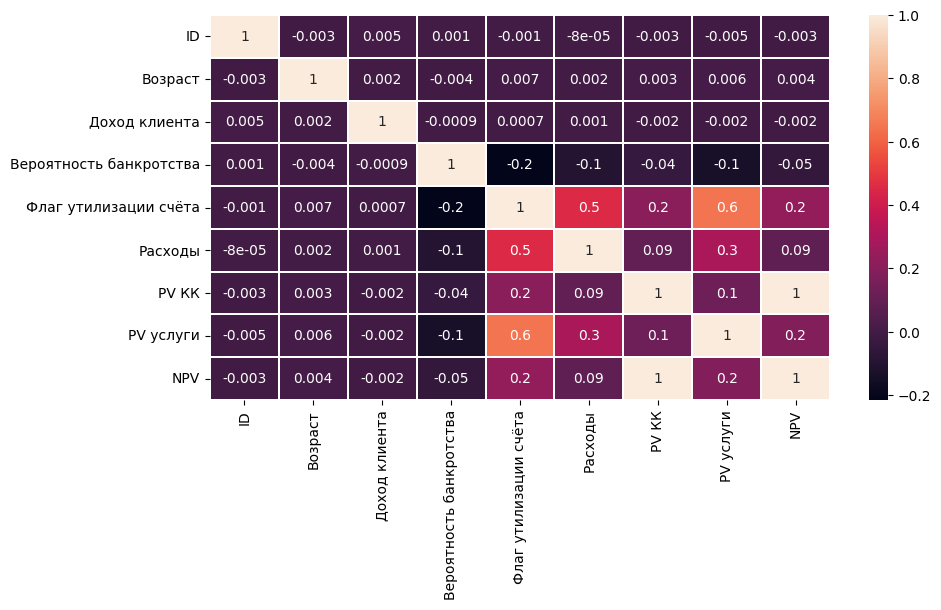

In [ ]:
plt.figure(figsize=[10,5])
sns.heatmap(df.corr(), annot = True, fmt='.1g', linewidths=.2)
plt.show()

Наибольшую корреляцию с NPV имеет параметр 'Вероятность банкротства' — оставим его в качестве параметра для проверки однородности.

#### Вычислим размеры выборок для теста и контроля

In [ ]:
df.shape

(123255, 9)

Согласно условию, мы разбиваем весь поток на две части равновероятно. Всего в потоке 123255, в каждой из выборок будет по 61627 наблюдений.

**ПОЛУЧЕННЫЙ КОД ВЫБОРКИ — 12017**

In [ ]:
df_test = pd.read_csv("Тест_КК.csv")
df_control = pd.read_csv("Контроль_КК.csv")

In [ ]:
df_test.head()

,ID,Возраст,Доход клиента,Вероятность банкротства,Флаг утилизации счёта,Расходы,PV КК,PV услуги,NPV
0,0,61,26360.539774,0.069059,0,57,0,0,-57
1,1,30,72687.097593,0.001142,1,215,12730,1607,14122
2,2,36,22104.326029,0.051648,1,95,26816,2127,28848
3,3,19,36493.540045,0.160917,1,1077,8501,2888,10312
4,4,37,34438.898649,0.227528,1,3654,7326,2731,6403


In [ ]:
df_control.head()

,ID,Возраст,Доход клиента,Вероятность банкротства,Флаг утилизации счёта,Расходы,PV КК,PV услуги,NPV
0,0,29,20846.381885,0.238897,0,4,0,0,-4
1,1,59,23506.146921,0.122238,0,20,0,0,-20
2,2,32,28053.578085,0.173778,1,921,6123,1364,6566
3,3,33,22410.711770,0.086673,1,744,11016,1459,11731
4,4,21,31165.407449,0.023087,1,171,6759,1479,8067


#### Проверка однородности выборок по параметру 'Вероятность банкротства'

In [ ]:
from scipy.stats import ks_2samp
from scipy.stats import anderson_ksamp

ks_2samp(df_test['Вероятность банкротства'], df_control['Вероятность банкротства'])

KstestResult(statistic=0.0039917568598178965, pvalue=0.7084759258696558)

Вывод: p-value > 0.02, следовательно мы НЕ отвергаем гипотезу об однородности выборок теста и контроля.

#### Применим z-test для проверки изначальной гипотезы

In [ ]:
from statsmodels.stats.weightstats import ztest

mean_control = np.mean(df_control.NPV)
ztest(x1=df_test.NPV, x2=df_control.NPV, value=0, alternative='larger')

(1.5154207525220171, 0.0648329426184179)

**Вывод:** p-value > 0.05, следовательно мы НЕ отвергаем нулевую гипотезу о равенстве средних. Такимо образом, мы можем заключить, что изменение продукта не оправданы — мы не зафиксировали желаемой статистически значимой разницы.